In [1]:
# Import packages/data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error

train = pd.read_csv('train_bucket_5.csv')
valid = pd.read_csv('valid_bucket_5.csv')
test = pd.read_csv('test_bucket_5.csv')

# train['date'] = pd.to_datetime(train['date'])
# valid['date'] = pd.to_datetime(valid['date'])
# test['date'] = pd.to_datetime(test['date'])

train

,item_id,year,units_sold_5,sell_price_5,bucket_num
0,HOBBIES_1_001,2013,0,9.580,38
1,HOBBIES_1_001,2013,1,9.580,39
2,HOBBIES_1_001,2013,0,9.580,40
3,HOBBIES_1_001,2013,0,8.788,41
4,HOBBIES_1_001,2013,2,8.260,42
...,...,...,...,...,...
26185,HOBBIES_1_104,2015,1,23.980,65
26186,HOBBIES_1_104,2015,2,23.980,66
26187,HOBBIES_1_104,2015,2,23.980,67
26188,HOBBIES_1_104,2015,1,23.980,68


In [2]:
################################################################################################################################

In [3]:
# units_sold_bucket_mean feature engineering

In [4]:
# Determine mean units sold for a given item, in a given bucket, by averaging sales of product in given bucket over all years

train_mean_bucket_sales = train.groupby(['item_id','bucket_num'])['units_sold_5'].mean().reset_index()
train_mean_bucket_sales = train_mean_bucket_sales.rename(columns={"units_sold_5":"units_sold_bucket_overall_mean"})

valid_mean_bucket_sales = valid.groupby(['item_id','bucket_num'])['units_sold_5'].mean().reset_index()
valid_mean_bucket_sales = valid_mean_bucket_sales.rename(columns={"units_sold_5":"units_sold_bucket_overall_mean"})

train_mean_bucket_sales

,item_id,bucket_num,units_sold_bucket_overall_mean
0,HOBBIES_1_001,0,1.0
1,HOBBIES_1_001,1,3.5
2,HOBBIES_1_001,2,4.0
3,HOBBIES_1_001,3,1.5
4,HOBBIES_1_001,4,3.0
...,...,...,...
7295,HOBBIES_1_104,68,1.5
7296,HOBBIES_1_104,69,1.5
7297,HOBBIES_1_104,70,0.0
7298,HOBBIES_1_104,71,2.0


In [5]:
# Add new features to train/validation/test dfs (NOTICE: test monthly means are taken to be train monthly means!)

train_new = train.reset_index()
train_new = train_new.merge(train_mean_bucket_sales,on=['item_id','bucket_num'])
train_new = train_new.sort_values(by='index')
train_new = train_new.drop(columns='index')

valid_new = valid.reset_index()
valid_new = valid_new.merge(valid_mean_bucket_sales,on=['item_id','bucket_num'])
valid_new = valid_new.sort_values(by='index')
valid_new = valid_new.drop(columns='index')

test_new = test.reset_index()
test_new = test_new.merge(train_mean_bucket_sales,on=['item_id','bucket_num'])
test_new = test_new.sort_values(by='index')
test_new = test_new.drop(columns='index')

train_new

,item_id,year,units_sold_5,sell_price_5,bucket_num,units_sold_bucket_overall_mean
0,HOBBIES_1_001,2013,0,9.580,38,1.000000
3,HOBBIES_1_001,2013,1,9.580,39,4.666667
6,HOBBIES_1_001,2013,0,9.580,40,1.000000
9,HOBBIES_1_001,2013,0,8.788,41,2.000000
12,HOBBIES_1_001,2013,2,8.260,42,3.666667
...,...,...,...,...,...,...
26161,HOBBIES_1_104,2015,1,23.980,65,1.000000
26163,HOBBIES_1_104,2015,2,23.980,66,2.000000
26165,HOBBIES_1_104,2015,2,23.980,67,1.500000
26167,HOBBIES_1_104,2015,1,23.980,68,1.500000


In [6]:
################################################################################################################################

In [7]:
# monthly_rolling_mean feature engineering

In [8]:
# Rolling mean for train

ids = train_new.item_id.unique()
window = 3

df_new = train_new.copy()
df_new['bucket_rolling_mean_'+str(window)] = 0

df_new2 = df_new[df_new['item_id']==ids[0]]
df_new2['bucket_rolling_mean_'+str(window)] = df_new2['units_sold_5'].rolling(window,closed='left').mean()
df_new2 = df_new2.where(pd.notnull(df_new2), 0)

for i in range(1,len(ids)):
    
    df_dummy = df_new[df_new['item_id']==ids[i]]
    df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
    df_dummy = df_dummy.where(pd.notnull(df_dummy), 0)
    
    df_new2 = pd.concat([df_new2,df_dummy])

train_new = df_new2.copy()
train_new

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['bucket_rolling_mean_'+str(window)] = df_new2['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: 

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1919596703.py:16

,item_id,year,units_sold_5,sell_price_5,bucket_num,units_sold_bucket_overall_mean,bucket_rolling_mean_3
0,HOBBIES_1_001,2013,0,9.580,38,1.000000,0.000000
3,HOBBIES_1_001,2013,1,9.580,39,4.666667,0.000000
6,HOBBIES_1_001,2013,0,9.580,40,1.000000,0.000000
9,HOBBIES_1_001,2013,0,8.788,41,2.000000,0.333333
12,HOBBIES_1_001,2013,2,8.260,42,3.666667,0.333333
...,...,...,...,...,...,...,...
26161,HOBBIES_1_104,2015,1,23.980,65,1.000000,1.666667
26163,HOBBIES_1_104,2015,2,23.980,66,2.000000,1.666667
26165,HOBBIES_1_104,2015,2,23.980,67,1.500000,2.000000
26167,HOBBIES_1_104,2015,1,23.980,68,1.500000,1.666667


In [9]:
# Rolling mean for valid

df_new = valid_new.copy()
df_new['bucket_rolling_mean_'+str(window)] = 0

df_new2 = df_new[df_new['item_id']==ids[0]]
df_new2['bucket_rolling_mean_'+str(window)] = df_new2['units_sold_5'].rolling(window,closed='left').mean()
df_new2 = df_new2.where(pd.notnull(df_new2), 0)

for i in range(1,len(ids)):
    
    df_dummy = df_new[df_new['item_id']==ids[i]]
    df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
    df_dummy = df_dummy.where(pd.notnull(df_dummy), 0)
    
    df_new2 = pd.concat([df_new2,df_dummy])

valid_new = df_new2.copy()
valid_new

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['bucket_rolling_mean_'+str(window)] = df_new2['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: S

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['bucket_rolling_mean_'+str(window)] = df_dummy['units_sold_5'].rolling(window,closed='left').mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\3110711502.py:13

,item_id,year,units_sold_5,sell_price_5,bucket_num,units_sold_bucket_overall_mean,bucket_rolling_mean_3
0,HOBBIES_1_001,2015,0,8.26,59,0.0,0.000000
1,HOBBIES_1_001,2015,3,8.26,60,3.0,0.000000
2,HOBBIES_1_001,2015,2,8.26,61,2.0,0.000000
3,HOBBIES_1_001,2015,4,8.26,62,4.0,1.666667
4,HOBBIES_1_001,2015,2,8.26,63,2.0,3.000000
...,...,...,...,...,...,...,...
3341,HOBBIES_1_104,2016,4,23.98,8,4.0,1.666667
3342,HOBBIES_1_104,2016,1,23.98,9,1.0,2.000000
3343,HOBBIES_1_104,2016,2,23.98,10,2.0,2.000000
3344,HOBBIES_1_104,2016,2,23.98,11,2.0,2.333333


In [10]:
################################################################################################################################

In [11]:
# lag feature engineering

In [12]:
# Lag for train

ids = train_new.item_id.unique()
lag = 1

df_new = train_new.copy()
df_new['lag_'+str(lag)] = 0

df_new2 = df_new[df_new['item_id']==ids[0]]
df_new2['lag_'+str(lag)] = df_new2['units_sold_5'].shift(lag)
df_new2 = df_new2.where(pd.notnull(df_new2), 0)

df_new2

for i in range(1,len(ids)):
    
    df_dummy = df_new[df_new['item_id']==ids[i]]
    df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
    df_dummy = df_dummy.where(pd.notnull(df_dummy), 0)
    
    df_new2 = pd.concat([df_new2,df_dummy])

train_new = df_new2.copy()
train_new

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['lag_'+str(lag)] = df_new2['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1136405502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,item_id,year,units_sold_5,sell_price_5,bucket_num,units_sold_bucket_overall_mean,bucket_rolling_mean_3,lag_1
0,HOBBIES_1_001,2013,0,9.580,38,1.000000,0.000000,0.0
3,HOBBIES_1_001,2013,1,9.580,39,4.666667,0.000000,0.0
6,HOBBIES_1_001,2013,0,9.580,40,1.000000,0.000000,1.0
9,HOBBIES_1_001,2013,0,8.788,41,2.000000,0.333333,0.0
12,HOBBIES_1_001,2013,2,8.260,42,3.666667,0.333333,0.0
...,...,...,...,...,...,...,...,...
26161,HOBBIES_1_104,2015,1,23.980,65,1.000000,1.666667,3.0
26163,HOBBIES_1_104,2015,2,23.980,66,2.000000,1.666667,1.0
26165,HOBBIES_1_104,2015,2,23.980,67,1.500000,2.000000,2.0
26167,HOBBIES_1_104,2015,1,23.980,68,1.500000,1.666667,2.0


In [13]:
# Lag for valid

ids = valid_new.item_id.unique()
lag = 1

df_new = valid_new.copy()
df_new['lag_'+str(lag)] = 0

df_new2 = df_new[df_new['item_id']==ids[0]]
df_new2['lag_'+str(lag)] = df_new2['units_sold_5'].shift(lag)
df_new2 = df_new2.where(pd.notnull(df_new2), 0)

df_new2

for i in range(1,len(ids)):
    
    df_dummy = df_new[df_new['item_id']==ids[i]]
    df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
    df_dummy = df_dummy.where(pd.notnull(df_dummy), 0)
    
    df_new2 = pd.concat([df_new2,df_dummy])

valid_new = df_new2.copy()
valid_new

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['lag_'+str(lag)] = df_new2['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['lag_'+str(lag)] = df_dummy['units_sold_5'].shift(lag)
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\2477688734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,item_id,year,units_sold_5,sell_price_5,bucket_num,units_sold_bucket_overall_mean,bucket_rolling_mean_3,lag_1
0,HOBBIES_1_001,2015,0,8.26,59,0.0,0.000000,0.0
1,HOBBIES_1_001,2015,3,8.26,60,3.0,0.000000,0.0
2,HOBBIES_1_001,2015,2,8.26,61,2.0,0.000000,3.0
3,HOBBIES_1_001,2015,4,8.26,62,4.0,1.666667,2.0
4,HOBBIES_1_001,2015,2,8.26,63,2.0,3.000000,4.0
...,...,...,...,...,...,...,...,...
3341,HOBBIES_1_104,2016,4,23.98,8,4.0,1.666667,1.0
3342,HOBBIES_1_104,2016,1,23.98,9,1.0,2.000000,4.0
3343,HOBBIES_1_104,2016,2,23.98,10,2.0,2.000000,1.0
3344,HOBBIES_1_104,2016,2,23.98,11,2.0,2.333333,2.0


<AxesSubplot:>

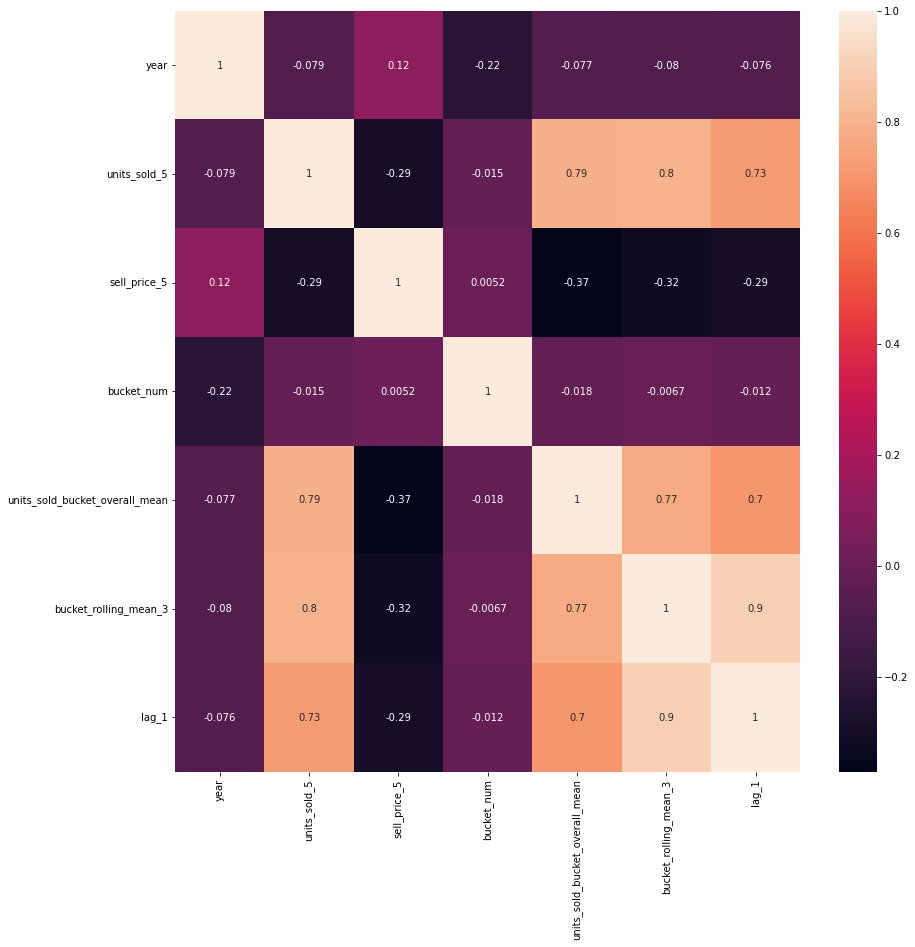

In [14]:
# Plot heatmap

fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(train_new.corr(),annot=True)

In [15]:
################################################################################################################################

In [16]:
# Create train/validation/test X and y

cols_to_drop = ['bucket_num','year']

train_df = train_new.drop(columns=cols_to_drop)
X_train = train_df.drop(columns='units_sold_5')
y_train = train_df['units_sold_5']

valid_df = valid_new.drop(columns=cols_to_drop)
X_valid = valid_df.drop(columns='units_sold_5')
y_valid = valid_df['units_sold_5']

test_df = test_new.drop(columns=cols_to_drop)
X_test = test_df.drop(columns='units_sold_5')
y_test = test_df['units_sold_5']

train_df

,item_id,units_sold_5,sell_price_5,units_sold_bucket_overall_mean,bucket_rolling_mean_3,lag_1
0,HOBBIES_1_001,0,9.580,1.000000,0.000000,0.0
3,HOBBIES_1_001,1,9.580,4.666667,0.000000,0.0
6,HOBBIES_1_001,0,9.580,1.000000,0.000000,1.0
9,HOBBIES_1_001,0,8.788,2.000000,0.333333,0.0
12,HOBBIES_1_001,2,8.260,3.666667,0.333333,0.0
...,...,...,...,...,...,...
26161,HOBBIES_1_104,1,23.980,1.000000,1.666667,3.0
26163,HOBBIES_1_104,2,23.980,2.000000,1.666667,1.0
26165,HOBBIES_1_104,2,23.980,1.500000,2.000000,2.0
26167,HOBBIES_1_104,1,23.980,1.500000,1.666667,2.0


In [17]:
# Define categorical features

cat_columns = ['item_id']
print("Names of categorical columns : ", cat_columns)

cat_idx = [X_train.columns.get_loc(col) for col in cat_columns]
print("Indices of categorical columns : ",cat_idx)

Names of categorical columns :  ['item_id']
Indices of categorical columns :  [0]


In [18]:
# Import the Pool class from catboost and use it for train/validation split

from catboost import Pool


train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_idx
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=cat_idx
                 )

C:\Users\16479\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
# Create catboost model and train it

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor(random_seed=2022, iterations=200, learning_rate=0.1)
model.fit(train_data, eval_set=valid_data)

# model = CatBoostRegressor(random_seed=2022)

# parameters = {'depth':[4,6,8,10],
#              'learning_rate':[0.01,0.05,0.1,0.5],
#               'iterations':[10,25,50,75,100]
#              }

# Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
# Grid_CBC.fit(X_train, y_train)
# Grid_CBC.best_params_

0:	learn: 10.3230075	test: 10.6375231	best: 10.6375231 (0)	total: 167ms	remaining: 33.2s
1:	learn: 9.6575754	test: 9.8731408	best: 9.8731408 (1)	total: 199ms	remaining: 19.7s
2:	learn: 9.0784326	test: 9.1565653	best: 9.1565653 (2)	total: 223ms	remaining: 14.6s
3:	learn: 8.5875380	test: 8.5271953	best: 8.5271953 (3)	total: 246ms	remaining: 12.1s
4:	learn: 8.1614838	test: 7.9911269	best: 7.9911269 (4)	total: 269ms	remaining: 10.5s
5:	learn: 7.7903911	test: 7.5084259	best: 7.5084259 (5)	total: 290ms	remaining: 9.37s
6:	learn: 7.4711880	test: 7.0818971	best: 7.0818971 (6)	total: 315ms	remaining: 8.69s
7:	learn: 7.1807666	test: 6.6282935	best: 6.6282935 (7)	total: 340ms	remaining: 8.15s
8:	learn: 6.9361275	test: 6.2890231	best: 6.2890231 (8)	total: 365ms	remaining: 7.74s
9:	learn: 6.7194731	test: 5.9476645	best: 5.9476645 (9)	total: 387ms	remaining: 7.35s
10:	learn: 6.5426774	test: 5.6649565	best: 5.6649565 (10)	total: 411ms	remaining: 7.05s
11:	learn: 6.3857343	test: 5.3597818	best: 5.3597

103:	learn: 5.1913798	test: 3.0375471	best: 3.0204352 (87)	total: 2.48s	remaining: 2.29s
104:	learn: 5.1865044	test: 3.0351071	best: 3.0204352 (87)	total: 2.51s	remaining: 2.27s
105:	learn: 5.1821609	test: 3.0318401	best: 3.0204352 (87)	total: 2.53s	remaining: 2.24s
106:	learn: 5.1811974	test: 3.0280263	best: 3.0204352 (87)	total: 2.55s	remaining: 2.21s
107:	learn: 5.1789196	test: 3.0286120	best: 3.0204352 (87)	total: 2.57s	remaining: 2.19s
108:	learn: 5.1770939	test: 3.0215615	best: 3.0204352 (87)	total: 2.59s	remaining: 2.17s
109:	learn: 5.1756229	test: 3.0205800	best: 3.0204352 (87)	total: 2.62s	remaining: 2.14s
110:	learn: 5.1732303	test: 3.0178833	best: 3.0178833 (110)	total: 2.64s	remaining: 2.11s
111:	learn: 5.1641418	test: 3.0312182	best: 3.0178833 (110)	total: 2.66s	remaining: 2.09s
112:	learn: 5.1631914	test: 3.0317820	best: 3.0178833 (110)	total: 2.68s	remaining: 2.06s
113:	learn: 5.1591898	test: 3.0228871	best: 3.0178833 (110)	total: 2.71s	remaining: 2.04s
114:	learn: 5.155

199:	learn: 4.9257517	test: 3.0376234	best: 2.9851320 (124)	total: 4.59s	remaining: 0us

bestTest = 2.98513203
bestIteration = 124

Shrink model to first 125 iterations.


In [20]:
# best: 3.4282983 (86)

Text(0.5, 1.0, 'Feature Importance')

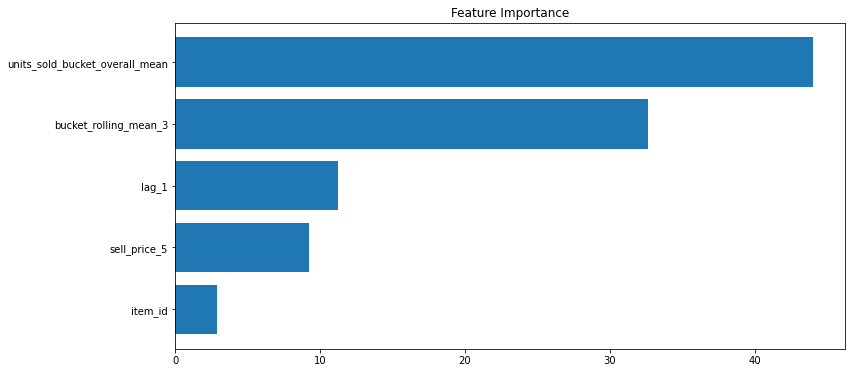

In [21]:
# Feature importance plot

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [22]:
################################################################################################################################

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['lag_'+str(lag)] = y
C:\Users\16479\AppData\Local\Temp\ipykernel_11340\1336982121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

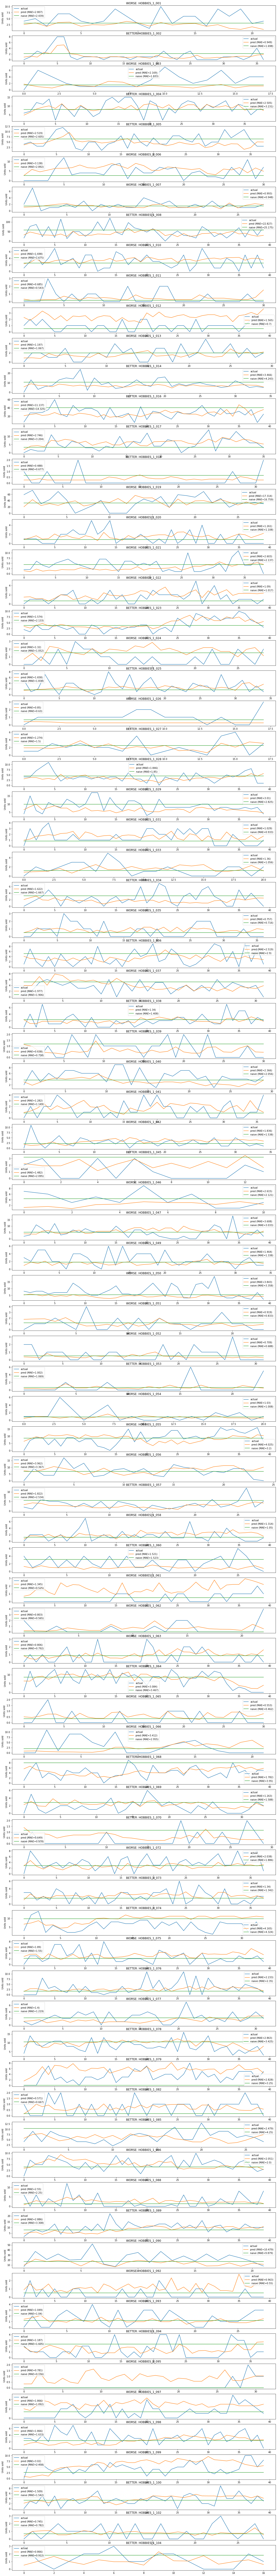

In [64]:
# Determine which product predictions beat naive model

from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('bucket_plots.pdf')

plot_rows = len(new_ids)
fig, ax = plt.subplots(nrows=plot_rows,ncols=1,figsize = (20,200))

counter = 0

ids = train.item_id.unique()

output = []

y_pred_MAE_list = []
y_naive_MAE_list = []

for ID in new_ids:

    X_test['bucket_rolling_mean_'+str(window)] = 0
    X_test['lag_'+str(lag)] = 0

    X_test_single = X_test[X_test['item_id']==ID].reset_index().drop(columns='index')
    valid_single = valid_df[valid_df['item_id']==ID]

    x = X_test_single.iloc[[0]]
    x['bucket_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold_5.mean()
    x['lag_'+str(lag)] = valid_single.tail(lag).units_sold_5
    
    X_test_single = X_test_single.drop(index=0)
    X_test_single = pd.concat([x,X_test_single])

    y_pred = []

    for i in range(0,window):

        x = X_test_single.iloc[[i]]

        if i!=0:
            x['bucket_rolling_mean_'+str(window)] = ( prev_sales.sum() + np.sum(y_pred) )/window
            x['lag_'+str(lag)] = y

        y = model.predict(x)[0]
        y_pred.append(y)

        prev_sales = valid_single.tail(window-(i+1))['units_sold_5'].to_numpy()

    rows = X_test_single.shape[0]

    for i in range(window,rows):
        x = X_test_single.iloc[[i]]
        x['bucket_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
        x['lag_'+str(lag)] = y
        y = model.predict(x)[0]
        y_pred.append(y)

    single_item_actuals_df = test_df[test_df['item_id']==ID]
    y_actual = single_item_actuals_df['units_sold_5'].to_numpy()

    naive_window = 6

    y_naive = valid_single.tail(naive_window).units_sold_5.mean()*np.ones(len(y_actual))

    y_pred_MAE = round(mean_absolute_error(y_actual,y_pred),3)
    y_pred_MAE_list.append(y_pred_MAE)

    y_naive_MAE = round(mean_absolute_error(y_actual,y_naive),3)
    y_naive_MAE_list.append(y_naive_MAE)

    if y_pred_MAE < y_naive_MAE:
        output.append(ID)

    if y_pred_MAE < y_naive_MAE:    
        ax[counter].set_title('BETTER: '+ID)
    else:
        ax[counter].set_title('WORSE: '+ID)

#     ax[counter].set_xlabel('Test month')
    ax[counter].set_ylabel('Units sold')

    ax[counter].plot(y_actual,label='actual')
    ax[counter].plot(y_pred,label='pred (MAE='+str(y_pred_MAE)+')')
    ax[counter].plot(y_naive,label='naive (MAE='+str(y_naive_MAE)+')')

    ax[counter].legend()

    counter += 1

pp.savefig(fig)
pp.close()

In [65]:
sum(y_pred_MAE_list), sum(y_naive_MAE_list)

(208.05300000000008, 212.16)

In [66]:
# Percentage of products where predictions beat naive model

len(output)/len(new_ids)

0.4235294117647059

In [47]:
# max_index_list = []
# diff = np.array(y_pred_MAE_list) - np.array(y_naive_MAE_list)

# for i in range(15):
#     MAX = max(diff)
#     max_index = list(diff).index(MAX)
#     max_index_list.append(max_index)
#     diff[max_index] = 0

# max_index_list.sort(reverse=True)
# max_index_list

[98, 88, 84, 81, 80, 78, 77, 65, 47, 43, 42, 31, 29, 14, 8]

In [48]:
# new_ids = list(ids)

# for index in max_index_list:
#     new_ids.pop(index)

# new_ids

['HOBBIES_1_001',
 'HOBBIES_1_002',
 'HOBBIES_1_003',
 'HOBBIES_1_004',
 'HOBBIES_1_005',
 'HOBBIES_1_006',
 'HOBBIES_1_007',
 'HOBBIES_1_008',
 'HOBBIES_1_010',
 'HOBBIES_1_011',
 'HOBBIES_1_012',
 'HOBBIES_1_013',
 'HOBBIES_1_014',
 'HOBBIES_1_016',
 'HOBBIES_1_017',
 'HOBBIES_1_018',
 'HOBBIES_1_019',
 'HOBBIES_1_020',
 'HOBBIES_1_021',
 'HOBBIES_1_022',
 'HOBBIES_1_023',
 'HOBBIES_1_024',
 'HOBBIES_1_025',
 'HOBBIES_1_026',
 'HOBBIES_1_027',
 'HOBBIES_1_028',
 'HOBBIES_1_029',
 'HOBBIES_1_031',
 'HOBBIES_1_033',
 'HOBBIES_1_034',
 'HOBBIES_1_035',
 'HOBBIES_1_036',
 'HOBBIES_1_037',
 'HOBBIES_1_038',
 'HOBBIES_1_039',
 'HOBBIES_1_040',
 'HOBBIES_1_041',
 'HOBBIES_1_042',
 'HOBBIES_1_045',
 'HOBBIES_1_046',
 'HOBBIES_1_047',
 'HOBBIES_1_049',
 'HOBBIES_1_050',
 'HOBBIES_1_051',
 'HOBBIES_1_052',
 'HOBBIES_1_053',
 'HOBBIES_1_054',
 'HOBBIES_1_055',
 'HOBBIES_1_056',
 'HOBBIES_1_057',
 'HOBBIES_1_058',
 'HOBBIES_1_060',
 'HOBBIES_1_061',
 'HOBBIES_1_062',
 'HOBBIES_1_063',
 'HOBBIES_

In [49]:
# len(new_ids)

85

In [ ]:
################################################################################################################################

In [ ]:
# Make product-level predictions

In [ ]:
# Add in rolling mean column for test df

X_test['monthly_rolling_mean_'+str(window)] = 0
X_test

In [ ]:
# Slice test df for item of interest

item_id = 'HOBBIES_1_045'
X_test_single = X_test[X_test['item_id']==item_id].reset_index().drop(columns='index')

X_test_single

In [ ]:
# Slice validation df for item of interest

valid_single = valid_df[valid_df['item_id']==item_id]
valid_single

In [ ]:
# Insert rolling mean for first test date

x = X_test_single.iloc[[0]]
x['monthly_rolling_mean_'+str(window)] = valid_single.tail(window).units_sold.mean()
X_test_single = X_test_single.drop(index=0)
X_test_single = pd.concat([x,X_test_single])

X_test_single

In [ ]:
# Recursively predict sales for test days where rolling mean must be calculated using validation df

y_pred = []

if valid_single.shape[0] < window or X_test_single.shape[0] < window:
    
    print('BROKE!')

else:

    for i in range(0,window):

        x = X_test_single.iloc[[i]]

        if i!=0:
            x['monthly_rolling_mean_'+str(window)] = ( prev_sales.sum() + np.sum(y_pred) )/window

        y = model.predict(x)[0]
        y_pred.append(y)

        prev_sales = valid_single.tail(window-(i+1))['units_sold'].to_numpy()

y_pred

In [ ]:
# Recursively predict sales for rest of test days

rows = X_test_single.shape[0]

for i in range(window,rows):
    x = X_test_single.iloc[[i]]
    x['monthly_rolling_mean_'+str(window)] = np.sum(y_pred[i-window:i])/window
    y = model.predict(x)[0]
    y_pred.append(y)

y_pred

In [ ]:
################################################################################################################################

In [ ]:
# Get actuals

single_item_actuals_df = test_df[test_df['item_id']==item_id]
y_actual = single_item_actuals_df['units_sold'].to_numpy()

y_actual

In [ ]:
# Plot predictions vs actuals

naive_window = 6

y_naive = valid_single.tail(naive_window).units_sold.mean()*np.ones(len(y_actual))

y_pred_MSE = round(mean_squared_error(y_actual,y_pred),3)
y_naive_MSE = round(mean_squared_error(y_actual,y_naive),3)

figure(figsize=(20, 10))

plt.plot(y_actual,label='actual')
plt.plot(y_pred,label='pred (MSE='+str(y_pred_MSE)+')')
plt.plot(y_naive,label='mean pre-test (MSE='+str(y_naive_MSE)+')')

plt.legend()

In [ ]:
################################################################################################################################

In [ ]:
# Rough work

In [ ]:
# Let's take a look at a single product's sales

# item_id = 'HOBBIES_1_012'
df2 = df[df['item_id']==item_id]

df2 = df2[['date','units_sold']]
df2 = df2.set_index('date')

df2

In [ ]:
# Decompose time series and plot

from statsmodels.tsa.seasonal import seasonal_decompose

decomp_viz = seasonal_decompose(df2)

fig = decomp_viz.plot()
fig.set_size_inches((20, 20))
fig.tight_layout()
plt.show()